In [ ]:
# 该图像在x方向上和y方向上的梯度图：
import numpy as np
import cv2
from matplotlib import pyplot as plt
img = cv2.imread('/home/zsy004/CT/HeadCT/000000.jpeg', 0)
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

plt.subplot(1, 3, 1), plt.imshow(img, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 2), plt.imshow(sobelx, cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 3),plt.imshow(sobely, cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()
img

### 三、Canny边缘检测算法（代码实现）
参数含义如下：
```
edge = cv2.Canny(image, threshold1, threshold2[, edges[, apertureSize[, L2gradient ]]]) 
image：要检测的图像
threshold1：阈值1（最小值）
threshold2：阈值2（最大值），使用此参数进行明显的边缘检测
edges：图像边缘信息
apertureSize：sobel算子（卷积核）大小
L2gradient ：布尔值。
True： 使用更精确的L2范数进行计算（即两个方向的导数的平方和再开方）
False：使用L1范数（直接将两个方向导数的绝对值相加）
```


In [ ]:
from matplotlib import pyplot as plt
v1 = cv2.Canny(img, 80, 150, (3, 3))
v2 = cv2.Canny(img, 50, 100, (5, 5))
v3 = cv2.Canny(img, 50, 100, (5, 5),L2gradient=False)
# np.vstack():在竖直方向上堆叠
# np.hstack():在水平方向上平铺堆叠
# ret = np.hstack((v1, v2))
# 使用plt.subplot来创建小图. plt.subplot(141)表示将整个图像窗口分为1行4列, 当前位置为1.
plt.figure(figsize=(20, 20)) 
plt.rcParams['figure.dpi'] = 600 #分辨率
plt.subplot(141),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(142),plt.imshow(v1,cmap = 'gray')
plt.title('Edge Image1'), plt.xticks([]), plt.yticks([])
plt.subplot(143),plt.imshow(v2,cmap = 'gray')
plt.title('Edge Image2'), plt.xticks([]), plt.yticks([])
plt.subplot(144),plt.imshow(v3,cmap = 'gray')
plt.title('Edge Image3'), plt.xticks([]), plt.yticks([])
plt.show()
# plt.savefig('v3.png', dpi=300) #指定分辨率保存

批量读取一个文件夹下所有的图片并处理

In [1]:
import os
import numpy as np
import cv2
src_dir='/home/ubuntu/data_process/dcm_2_png/N'
files = os.listdir(src_dir)
i=0
for s in files:
    img = cv2.imread(src_dir + '/' + s, 0)
    ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    N_Otus=cv2.Canny(th2, 50, 100, (3, 3))
    img_path = "/home/ubuntu/data_process/contour/N/" + "N_."+str(i) +".png"
    cv2.imwrite(img_path, N_Otus) 
    i+=1

Python对DICOM图像进行阈值分割

In [ ]:
import cv2
import numpy
import pydicom as dicom
from matplotlib import pyplot as plt

# 读取单张Dicom图像
dcm = dicom.read_file("/home/zsy004/CT/CT_Data/craniosynostosis/0t2/Cheng An Zhi78607961/20210225200843.000000/201/78607961_20210225_201_191.dcm")
dcm.image = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept

# 获取图像中的像素数据
slices = []
slices.append(dcm)

# 复制Dicom图像中的像素数据
img = slices[ int(len(slices)/2) ].image.copy()

# 对图像进行阈值分割
ret,img = cv2.threshold(img, 90,3071, cv2.THRESH_BINARY)
img = numpy.uint8(img)

# 提取分割结果中的轮廓，并填充孔洞
im2, contours = cv2.findContours(img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
mask = numpy.zeros(img.shape, numpy.uint8)
for contour in contours:
    cv2.fillPoly(mask, [contour], 255)
img[(mask > 0)] = 255

# 对分割结果进行形态学的开操作
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# 根据分割mask获取分割结果的像素数据
img2 = slices[ int(len(slices)/2) ].image.copy()
img2[(img == 0)] = -2000

# 显式原始数据，mask和分割结果
plt.figure(figsize=(12, 12))
plt.subplot(131)
plt.imshow(slices[int(len(slices) / 2)].image, 'gray')
plt.title('Original')
plt.subplot(132)
plt.imshow(img, 'gray')
plt.title('Mask')
plt.subplot(133)
plt.imshow(img2, 'gray')
plt.title('Result')
plt.show()

### Otsu's二值化
cv2.threshold( )函数有两个返回值，一个是阈值，第二个是处理后的图像矩阵。

前面对于阈值的设定上，我们选择的阈值都是127，在实际情况中，有的图像阈值不是127得到的图像效果更好。那么这里就需要算法自己去寻找一个阈值，而Otsu's就可以自己找到一个认为最好的阈值。并且Otsu's非常适合于图像灰度直方图(只有灰度图像才有)具有双峰的情况。他会在双峰之间找到一个值作为阈值，对于非双峰图像，可能并不是很好用。那么经过Otsu's得到的那个阈值就是函数cv2.threshold的第一个参数了。因为Otsu's方法会产生一个阈值，那么函数cv2.threshold( )的第二个参数（设定阈值）就是0了，并且在cv2.threshold的方法参数中还得加上语句cv2.THRESH_OTSU.



In [6]:
img = cv2.imread('/home/ubuntu/data_process/contour/N/N_.24.png', 0)# 读取为灰度图像
# 简单滤波
ret1, th1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)  
 # Otsu 滤波(阈值，计算矩阵)
ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) 
imgB = cv2.blur(th2, (3,3))  # Blur平滑后再做变换


# cv2.imshow('img', img)
# cv2.imshow('th1', th1)
# cv2.imshow('th2', th2)
# 用于解决matplotlib中显示图像的中文乱码问题
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
# plt.hist(img.ravel(), 256)
# plt.title('gray')

#边缘检测
v2 = cv2.Canny(img, 50, 100, (3, 3))
#双边滤波
b=cv2.bilateralFilter(img,55,100,100)

# 基于边缘检测的图像分割
#边缘检测之Sobel 算子
Sobel = cv2.Sobel (img, cv2.CV_64F, 0, 1, ksize=5)

#Laplacian 算子
Laplacian= cv2.Laplacian(img, cv2.CV_64F)

# Scharr 算子
Scharr = cv2.Scharr(img, cv2.CV_64F, 0, 1)

# 基于 K-Means 聚类的区域分割

#K-means均值聚类
Z = imgB.reshape((-1, 4))
Z = np.float32(Z)      #转化数据类型
c = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 2   #聚类中心个数，一般来说也代表聚类后的图像中的颜色的种类
ret, label, center = cv2.kmeans(Z, k, None, c, 10, cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
K_means = res.reshape((imgB.shape))


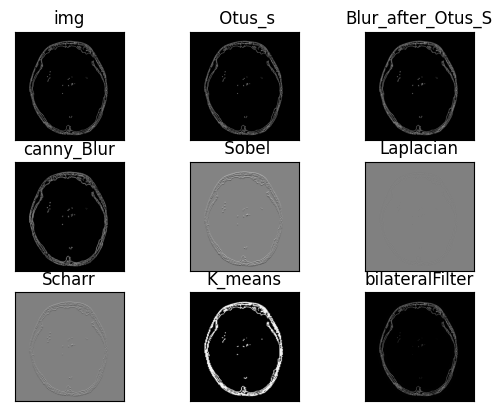

In [7]:
# plt.rcParams['figure.dpi'] = 1000 #分辨率
# plt.figure(figsize=(20, 20)) 
# 如果不想显示x轴刻度，则传入空列表即可
plt.subplot(331),plt.imshow(img,cmap = 'gray')
plt.title('img'), plt.xticks([]), plt.yticks([])
# plt.subplot(142),plt.imshow(th1,cmap = 'gray')
# plt.title('original'), plt.xticks([]), plt.yticks([])
plt.subplot(332),plt.imshow(th2,cmap = 'gray')
plt.title(' Otus_s'), plt.xticks([]), plt.yticks([])
plt.subplot(334),plt.imshow(v2,cmap = 'gray')
plt.title('canny_Blur'), plt.xticks([]), plt.yticks([])
plt.subplot(339),plt.imshow(b,cmap = 'gray')
plt.title('bilateralFilter'), plt.xticks([]), plt.yticks([])
plt.subplot(335),plt.imshow(Sobel,cmap = 'gray')
plt.title(' Sobel'), plt.xticks([]), plt.yticks([])
plt.subplot(336),plt.imshow(Laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(337),plt.imshow(Scharr,cmap = 'gray')
plt.title('Scharr'), plt.xticks([]), plt.yticks([])
plt.subplot(338),plt.imshow(K_means,cmap = 'gray')
plt.title('K_means'), plt.xticks([]), plt.yticks([])
plt.subplot(333),plt.imshow(imgB,cmap = 'gray')
plt.title('Blur_after_Otus_S'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
#批量处理Dicom文件
import os
import SimpleITK
import pydicom as dicom
import numpy as np
import cv2
from tqdm import tqdm

OpenCV图像轮廓（2）轮廓面积
轮廓contour \
特征feature\
面积area\
弧长perimeter\
图像矩image moment\
通过cv2.contourArea可以求得轮廓面积\。
通过一个例子来演示一下，例如，想要过滤掉那些微小琐碎的轮廓，只显示lena这幅图中面积大于500的轮廓。代码思路是将findContours查找到的轮廓按照面积排序，然后绘制

-----------------------------
版权声明：本文为CSDN博主「花小也盛开」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/greatwall_sdut/article/details/108862018

In [6]:
# img = cv2.imread('/home/zsy004/CT/dcm_2_png/img_0012.png', 0)#
def contour_area():
    img = cv2.imread('/home/zsy004/CT/png_2_contour/C_Otus.25.png', cv2.IMREAD_GRAYSCALE)
    ret, thresh = cv2.threshold(img, 160, 255, cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # 复制原图
    img1 = img.copy()
    # 创建一幅相同大小的白色图像
    img2 = np.ones(img.shape)
    # 按照面积将所有轮廓逆序排序
    contours2 = sorted(contours, key=lambda a: cv2.contourArea(a), reverse=True)
    for c in contours2:
        area = cv2.contourArea(c)
        print(area)
        # 只输出面积大于500轮廓
        if area<500:break
        # 分别在复制的图像上和白色图像上绘制当前轮廓
        cv2.drawContours(img1, [c],0, (0,255,0), 3)
        cv2.drawContours(img2, [c],0, (0,255,0), 3)
    plot_images(1,3,[img,img1,img2], gray=True)
    
    

# 区域生长算法

In [5]:
# -*- coding:utf-8 -*-
import cv2
import numpy as np
from matplotlib import pyplot as plt
####################################################################################

#######################################################################################
class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def getX(self):
        return self.x
    def getY(self):
        return self.y
connects = [Point(-1, -1), Point(0, -1), Point(1, -1), Point(1, 0),
            Point(1, 1), Point(0, 1), Point(-1, 1), Point(-1, 0)]
#####################################################################################
# 计算两个点间的欧式距离
def get_dist(seed_location1, seed_location2):
    l1 = im[seed_location1.x, seed_location1.y]
    l2 = im[seed_location2.x, seed_location2.y]
    count = np.sqrt(np.sum(np.square(l1-l2)))
    return count

# import Image
im = cv2.imread('/home/ubuntu/data_process/contour/C_Otus.276.png',cv2.IMREAD_GRAYSCALE)
# cv2.imshow('src', im)
# plt.subplot(141),plt.imshow(im,cmap = 'gray')
# plt.title('img'), plt.xticks([]), plt.yticks([])
# cv2.waitKey(0)
# cv2.destroyAllWindows()
im_shape = im.shape
height = im_shape[0]
width = im_shape[1]

print('the shape of image :', im_shape)

# 标记，判断种子是否已经生长
img_mark = np.zeros([height, width])
# cv2.imshow('img_mark', img_mark)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# plt.subplot(142),plt.imshow(img_mark,cmap = 'gray')
# plt.title('img_mark'), plt.xticks([]), plt.yticks([])

# 建立空的图像数组,作为一类
img_re = im.copy()
for i in range(height):
    for j in range(width):
        img_re[i, j][0] = 0
        img_re[i, j][1] = 0
        img_re[i, j][2] = 0
# cv2.imshow('img_re', img_re)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# plt.subplot(143),plt.imshow(img_re,cmap = 'gray')
# plt.title('img_re'), plt.xticks([]), plt.yticks([])
# 取一点作为种子点
seed_list = []
seed_list.append(Point(15, 15))
T = 7           # 阈值
class_k = 1     # 类别
# 生长一个类
while (len(seed_list) > 0):
    seed_tmp = seed_list[0]
    # 将以生长的点从一个类的种子点列表中删除
    seed_list.pop(0)

    img_mark[seed_tmp.x, seed_tmp.y] = class_k

    # 遍历8邻域
    for i in range(8):
        tmpX = seed_tmp.x + connects[i].x
        tmpY = seed_tmp.y + connects[i].y

        if (tmpX < 0 or tmpY < 0 or tmpX >= height or tmpY >= width):
            continue
        dist = get_dist(seed_tmp, Point(tmpX, tmpY))
        # 在种子集合中满足条件的点进行生长
        if (dist < T and img_mark[tmpX, tmpY] == 0):
            img_re[tmpX, tmpY][0] = im[tmpX, tmpY][0]
            img_re[tmpX, tmpY][1] = im[tmpX, tmpY][1]
            img_re[tmpX, tmpY][2] = im[tmpX, tmpY][2]
            img_mark[tmpX, tmpY] = class_k
            seed_list.append(Point(tmpX, tmpY))

########################################################################################
# 输出图像
# cv2.imshow('OUTIMAGE', img_re)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.subplot(111),plt.imshow(img_re,cmap = 'gray')
plt.title('OUTIMAGE'), plt.xticks([]), plt.yticks([])

[ WARN:0@334.018] global loadsave.cpp:244 findDecoder imread_('/home/ubuntu/data_process/contour/C_Otus.276.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [3]:
import numpy as np
import cv2

class Point(object):
    def __init__(self,x,y):
        self.x = x
        self.y = y
 
    def getX(self):
        return self.x
    def getY(self):
        return self.y
 
def getGrayDiff(img,currentPoint,tmpPoint):
    return abs(int(img[currentPoint.x,currentPoint.y]) - int(img[tmpPoint.x,tmpPoint.y]))
 
def selectConnects(p):
    if p != 0:
        connects = [Point(-1, -1), Point(0, -1), Point(1, -1), Point(1, 0), Point(1, 1), \
                    Point(0, 1), Point(-1, 1), Point(-1, 0)]
    else:
        connects = [ Point(0, -1),  Point(1, 0),Point(0, 1), Point(-1, 0)]
    return connects
 
def regionGrow(img,seeds,thresh,p = 1):
    height, weight = img.shape
    seedMark = np.zeros(img.shape)
    seedList = []
    for seed in seeds:
        seedList.append(seed)
    label = 1
    connects = selectConnects(p)
    while(len(seedList)>0):
        currentPoint = seedList.pop(0)
 
        seedMark[currentPoint.x,currentPoint.y] = label
        for i in range(8):
            tmpX = currentPoint.x + connects[i].x
            tmpY = currentPoint.y + connects[i].y
            if tmpX < 0 or tmpY < 0 or tmpX >= height or tmpY >= weight:
                continue
            grayDiff = getGrayDiff(img,currentPoint,Point(tmpX,tmpY))
            if grayDiff < thresh and seedMark[tmpX,tmpY] == 0:
                seedMark[tmpX,tmpY] = label
                seedList.append(Point(tmpX,tmpY))
    return seedMark
 
 
img = cv2.imread('/home/ubuntu/data_process/contour/N/N_.2141.png',0)
# img_save_path='/home/ubuntu/data_process/result'
seeds = [Point(10,10),Point(82,150),Point(20,300)]
binaryImg = regionGrow(img,seeds,10)
# cv2.imshow(' ',binaryImg)
# # cv2.waitKey(0)
# imsave(img_save_path, binaryImg)
#  img = cv2.imread(src_dir + '/' + s, 0)
ret2, th2 = cv2.threshold(binaryImg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
N_Otus=cv2.Canny(th2, 50, 100, (3, 3))
plt.subplot(121),plt.imshow(binaryImg,cmap = 'gray')
plt.title('OUTIMAGE'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(N_Otus,cmap = 'gray')
plt.title('N_Otus'), plt.xticks([]), plt.yticks([])

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/thresh.cpp:1555: error: (-2:Unspecified error) in function 'double cv::threshold(cv::InputArray, cv::OutputArray, double, double, int)'
> THRESH_OTSU mode:
>     'src_type == CV_8UC1 || src_type == CV_16UC1'
> where
>     'src_type' is 6 (CV_64FC1)


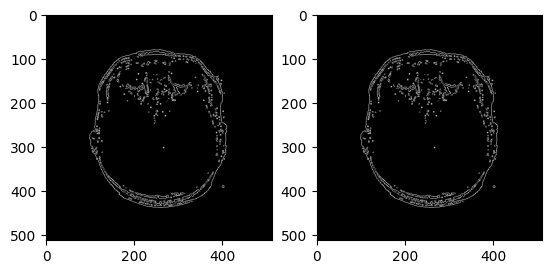

In [6]:
### 图像去噪
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('/home/ubuntu/data_process/contour/N/N_.2141.png')

dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(dst)
plt.show()



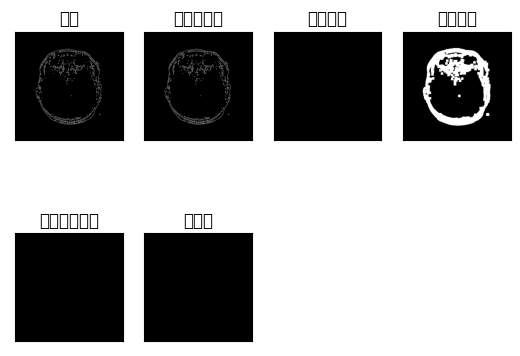

In [5]:
#图像侵蚀和膨胀
import cv2
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties
# font = FontProperties(fname=r"c:\windows\fonts\SimSun.ttc",size = 14)
im1 = cv2.imread('/home/ubuntu/data_process/contour/N/N_.2141.png',0)
# im2 = cv2.cvtColor(im1,cv2.COLOR_BGR2RGB)
# gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
ret,im_fixed = cv2.threshold(im1,120,255,cv2.THRESH_BINARY)  #ret:阈值；  im_fixed：处理结果

# 1.3 腐蚀处理: 将图像中的高亮区域或白色部分进行缩减细化
# 图像腐蚀的过程：
# a.图像二值化，将图像的灰度值根据阈值进行0，1处理得到的图像；
# b.卷积核，对应信号处理中的高低频滤波器。常用numpy去设置，np.ones((m,n), np.uint8) 表示指定m*n的卷积核；
# c.图像的腐蚀，cv2.erode(二值化图像, 卷积核, 迭代次数)
# 灰度级中的0表示白色；1表示黑色。将设置的卷积核与原图像做’与’运算,如果都为0，则标志点为0,否则为1。

#设置卷积核：可调节大小
kernel = np.ones((10,10), np.uint8)
f_sh = cv2.erode(im_fixed, kernel,5) #迭代5次
# 1.4 图像膨胀:将图像中的高亮区域或白色部分进行扩张
# 图像膨胀时腐蚀的逆过程，往往先通过腐蚀使图片线条变窄，然后腐蚀可以去除噪声。图像膨胀的处理过程：
# a.图像二值化，将图像的灰度值根据阈值进行0，1处理得到的图像；
# b.卷积核，对应信号处理中的高低频滤波器。常用numpy去设置，np.ones((m,n), np.uint8) 表示指定m*n的卷积核；
# c.图像的腐蚀，cv2.dilate(二值化图像, 卷积核, 迭代次数)

# 卷积核与原图像做’或’运算,如果两者中有一为0，则标志点为0,否则为1
p_zh = cv2.dilate(im_fixed, kernel,5)
q_z = cv2.dilate(f_sh, kernel,5)   #把腐蚀处理过的图像再进行膨胀处理

# 1.5图像开运算:先腐蚀后膨胀 有利于去除噪声（去除黑色区域中的白点）
k_ys = cv2.morphologyEx(im_fixed, cv2.MORPH_OPEN, kernel)
#显示图像
titles1 = ["原图","二值化处理",'腐蚀处理',"膨胀处理","先腐蚀后膨胀",'开运算']
images1 = [im1,im_fixed,f_sh,p_zh,q_z,k_ys]

for i in range(6):
    plt.subplot(2,4,i+1)
    plt.imshow(images1[i],'gray')   ##"gray"!!!!!!显示的图像中有灰度图!!!!!!
    plt.title(titles1[i])
    plt.xticks([]), plt.yticks([])
plt.show()


## 最大联通区域

(Text(0.5, 1.0, 'OUTIMAGE'), ([], []), ([], []))

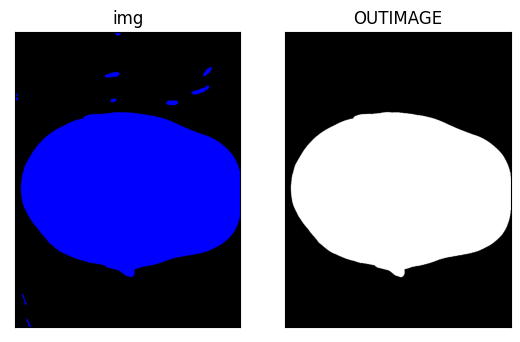

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def select_max_region(mask):
    nums, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    background = 0
    for row in range(stats.shape[0]):
        if stats[row, :][0] == 0 and stats[row, :][1] == 0:
            background = row
    stats_no_bg = np.delete(stats, background, axis=0)
    max_idx = stats_no_bg[:, 4].argmax()
    max_region = np.where(labels==max_idx+1, 1, 0)

    return max_region


img = cv2.imread('/home/ubuntu/data_process/3D_T_2D/result.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)[1]
mask = select_max_region(mask)*255
cv2.imwrite('/home/ubuntu/data_process/3D_T_2D/model_mask.png', mask) 
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('img'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(mask,cmap = 'gray')
plt.title('OUTIMAGE'), plt.xticks([]), plt.yticks([])
# cv2.imwrite('/Users/nickccnie/Desktop/images1.png', mask*255)


In [10]:
#批量处理
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt


def select_max_region(mask):
    nums, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    background = 0
    for row in range(stats.shape[0]):
        if stats[row, :][0] == 0 and stats[row, :][1] == 0:
            background = row
    stats_no_bg = np.delete(stats, background, axis=0)
    max_idx = stats_no_bg[:, 4].argmax()
    max_region = np.where(labels==max_idx+1, 1, 0)

    return max_region

src_dir='/home/ubuntu/data_process/contour/N'
files = os.listdir(src_dir)
i=0
for s in files:
    img = cv2.imread(src_dir + '/' + s, 0)
    # img = cv2.imread('/home/ubuntu/data_process/contour/C_Otus.10.png')
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]
    mask = select_max_region(mask)*255
    img_path = "/home/ubuntu/data_process/CT_Result/N/" + "N "+str(i) +".png"
    cv2.imwrite(img_path, mask) 
    i+=1
    
    

ValueError: attempt to get argmax of an empty sequence

## OpenCV 通过计算连通域面积过滤面积小的区域–Python

cv2.connectedComponentsWithStats <br>
函数：connectedComponentsWithStats(image, connectivity=8, cv2.CV_32S)<br>
功能：求得最大连通域。<br>
输入：假如image为128x128大小的图片，有7个连通域。<br>
返回：<br>
num_labels：连通域个数，此处为7；<br>
labels：大小128x128，标记图，图中不同连通域使用不同的标记（当前像素是第几个轮廓），和原图宽高一致；<br>
stats：大小7x5，每行5个数分别对应各个轮廓的x,y,width,height和面积。注意0的区域标识的是background;<br>
centroids：大小7x2，分别对应各个轮廓的中心点。<br>
<br>
此时可比较stats中各连通域的面积与阈值面积（此处取平均面积area_avg），保留大于阈值的面积即可。<br>


轮廓0的面积:261412
轮廓1的面积:732
轮廓平均面积: nan


(Text(0.5, 1.0, 'img'), ([], []), ([], []))

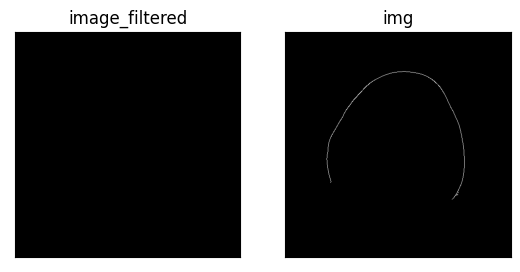

In [25]:
import numpy as np
import cv2 as cv

# 加载图片
img = cv.imread('/home/ubuntu/data_process/CT_Result/C/C_2.png',0)
# 灰度化
# img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# 二值化
ret, thresh = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
# 寻找连通域
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(thresh, connectivity=8)

# 计算平均面积
areas = list()
for i in range(num_labels):
    areas.append(stats[i][-1])
    print("轮廓%d的面积:%d" % (i, stats[i][-1]))
    

area_avg = np.average(areas[1:-1])
print("轮廓平均面积:", area_avg)

# 筛选超过平均面积的连通域
image_filtered = np.zeros_like(img)
for (i, label) in enumerate(np.unique(labels)):
    # 如果是背景，忽略
    if label == 0:
        continue
    if stats[i][-1] > area_avg :
        image_filtered[labels == i] = 255

# cv.imshow("image_filtered", image_filtered)
# cv.imshow("img", img)
# cv.waitKey()
# cv.destroyAllWindows()

plt.subplot(121),plt.imshow(image_filtered,cmap = 'gray')
plt.title('image_filtered'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img,cmap = 'gray')
plt.title('img'), plt.xticks([]), plt.yticks([])

(Text(0.5, 1.0, 'img_approx'), ([], []), ([], []))

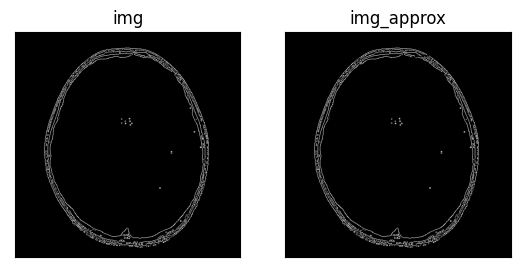

In [9]:
import cv2
import numpy as np
 
# 图像预处理
img = cv2.imread('/home/ubuntu/data_process/contour/N/N_.2158.png', 0)  # 灰度图
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edge = cv2.Canny(img, 160, 230)
# 查找轮廓
contours, hierarchy = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
c = sorted(contours, key=cv2.contourArea, reverse=True)  # 轮廓排序
# 构造逼近多边形
ep = 0.1 * cv2.arcLength(c[0],True)  # 精度
approx = cv2.approxPolyDP(c[0], ep, True)  
img_approx = cv2.drawContours(img.copy(),[approx],0,(0,255,0),2)  # 绘制多边形
# cv2.imshow("img_approx", img_approx)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('img'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_approx,cmap = 'gray')
plt.title('img_approx'), plt.xticks([]), plt.yticks([])

In [33]:
import numpy as np
import cv2 as cv

# 加载图片
img = cv.imread('Contour area screening.png')
# 灰度化
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# 二值化
ret, thresh = cv.threshold(img_gray, 127, 255, cv.THRESH_BINARY)
# 寻找轮廓
image, contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# 计算平均面积
areas = list()
for i in range(len(contours)):
    area = cv.contourArea(contours[i], False)
    areas.append(area)
    print("轮廓%d的面积:%d" % (i, area))

area_avg = np.average(areas)
print("轮廓平均面积:", area_avg)

# 筛选超过平均面积的轮廓
img_contours = []
for i in range(len(contours)):
    img_temp = np.zeros(img.shape, np.uint8)
    img_contours.append(img_temp)

    area = cv.contourArea(contours[i], False)
    if area > area_avg:
        print("轮廓%d的面积是: %d" % (i, area))
        cv.drawContours(img_contours[i], contours, i, (0, 0, 255), 5)
        cv.imshow("contours %d" % i, img_contours[i])

cv.imshow("img", img)
cv.waitKey()
cv.destroyAllWindows()


[ WARN:0@10770.784] global loadsave.cpp:244 findDecoder imread_('Contour area screening.png'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [42]:
import cv2
import numpy as np
imgPath ='/home/ubuntu/data_process/CT_Result/C/C_7309.png'
 
# 反转 黑白变换  一般不需要这一步，我这张图片是在找轮廓的时候有图像的四个边也会
# 被当成轮廓，所以我先反转一下黑白交换
 
im_in = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE);

# 复制 im_in 图像
im_floodfill = im_in.copy()

# Mask 用于 floodFill，官方要求长宽+2
h, w = im_in.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# floodFill函数中的seedPoint必须是背景
isbreak = False
for i in range(im_floodfill.shape[0]):
    for j in range(im_floodfill.shape[1]):
        if(im_floodfill[i][j]==0):
            seedPoint=(i,j)
            isbreak = True
            break
    if(isbreak):
        break
# 得到im_floodfill
cv2.floodFill(im_floodfill, mask, seedPoint, 255);

# 得到im_floodfill的逆im_floodfill_inv
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
# 把im_in、im_floodfill_inv这两幅图像结合起来得到前景
im_out = im_in | im_floodfill_inv
# cv2.imshow('de',im_out)
# cv2.waitKey(0)
# # cv2.destroyAllWindows()
# plt.subplot(111),plt.imshow(im_out,cmap = 'gray')
# plt.title('im_out'), plt.xticks([]), plt.yticks([])
im_floodfill_inv

<function ndarray.all>

## Head value description
### 颅骨指数（CI）
是通过测量头骨的最大宽度（ML）和最大头部长度（AP）计算得到的。具体来说，颅骨指数是头宽最大的部位与头长最大的部位相除后乘以100得到的比值，其计算公式为：

CI = (ML / AP) × 100

其中，ML表示头骨的最大宽度，通常是头骨两侧额颞部分的最大宽度；AP表示头骨的最大长度，通常是头骨前后部分的最大长度。

颅骨指数是一个常用的人类头骨形态学指标，可以用于研究不同人群或个体之间头骨形态的差异和发育变化。一般来说，颅骨指数在不同人群或个体之间存在一定的差异，例如，欧洲人的颅骨指数平均值约为75，而非洲人的颅骨指数平均值约为70左右。

### 颅顶不对称指数（CVAI）
是一种用于评估头骨不对称性的指标。它计算头部对角线尺寸之间的百分比差异，公式如下：

CVAI = (|A - B| / (A + B)) x 100

其中A和B为头部的对角线尺寸，|A - B|为两者差值的绝对值。CVAI越大表示头骨的不对称性越明显。

### 头颅前中线宽度比（AMWR）
是测量头颅前后宽度的指标，其公式为：AMWR = Ant / Mid<br>
其中，Ant代表头颅前宽度，Mid代表头颅中线宽度。
通常，AMWR被用来评估头颅的宽度对称性，以及头颅前后宽度的比例是否正常。正常的AMWR值通常在1.7至2.0之间，小于1.7可能表明头颅前突或头颅后缩，而大于2.0则可能表明头颅前缩或头颅后突。

In [10]:
#CI
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读入头颅图像
img = cv2.imread("/home/ubuntu/data_process/CT_Result/N_unet/N.23.png", cv2.IMREAD_GRAYSCALE)

# 二值化头颅图像
thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# 提取头颅轮廓
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)

# 计算最大宽度和最大头部长度
x, y, w, h = cv2.boundingRect(max_contour)
max_width = w
max_length = h

# 计算颅骨指数
CI = (max_width / max_length) * 100

# 显示结果
print("最大宽度为：", max_width, "像素")
print("最大头部长度为：", max_length, "像素")
print("颅骨指数为：", CI)
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_color, [max_contour], -1, (0, 165, 255), 2)
cv2.namedWindow("Head", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Head", 800, 600)
cv2.imshow("Head", img_color)
cv2.waitKey(0)
cv2.destroyAllWindows()
# plt.subplot(111),plt.imshow(img,cmap = 'gray')
# plt.title('Head'), plt.xticks([]), plt.yticks([])
# plt.subplot(111),plt.imshow(img,cmap = 'gray')
# plt.title('Head'), plt.xticks([]), plt.yticks([])

最大宽度为： 196 像素
最大头部长度为： 274 像素
颅骨指数为： 71.53284671532847


A对角线长度为： 459.2545935846915 像素
B对角线长度为： 347.10822040473784 像素
CVAI为： 24.419216431696437


(Text(0.5, 1.0, 'Head'), ([], []), ([], []))

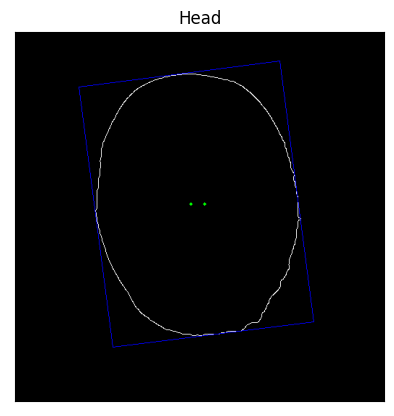

In [3]:
#CVAI
import cv2
import numpy as np
import matplotlib.pyplot as plt
# 读入头颅图像
img = cv2.imread("/home/ubuntu/data_process/CT_Result/N_unet/N.23.png", cv2.IMREAD_GRAYSCALE)

# 二值化头颅图像
thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# 提取头颅轮廓
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)

# 计算最大对角线长度
rect = cv2.minAreaRect(max_contour)
max_diag = max(rect[1])

# 计算对角线长度差异
A = np.sqrt(np.sum(np.square(rect[1])))
B = np.sqrt(np.sum(np.square(rect[0])))
CVAI = abs(A - B) / max(A, B) * 100

# 获取矩形的四个顶点坐标，并绘制出矩形
box = cv2.boxPoints(rect)
box = np.int0(box)
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_color, [box], 0, (0, 0, 255), 1)

# 获取矩形对角线上的交点，并绘制出交点
for i in range(2):
    pt1 = box[i]
    pt2 = box[i+2]
    k = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0])
    b = pt1[1] - k * pt1[0]
    x = int((rect[0][0] - b) / k)
    y = int(rect[0][1])
    cv2.circle(img_color, (x, y), 2, (0, 255, 0), -1)

# 显示结果
print("A对角线长度为：", A, "像素")
print("B对角线长度为：", B, "像素")
print("CVAI为：", CVAI)
# cv2.namedWindow("Head", cv2.WINDOW_NORMAL)
# cv2.resizeWindow("Head", 800, 600)
# cv2.imshow("Head", img_color)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.subplot(111),plt.imshow(img_color,cmap = 'gray')
plt.title('Head'), plt.xticks([]), plt.yticks([])